In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import OrderedDict
from collections import defaultdict

import dimod.generators as dg
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from Functions import *

In [38]:
#Constants
target_number = 143
num_bits = 6

#Jiang method parameters
t_penalty_multiplier = 100 #Only applies for the Jiang method
block_size = 3

In [32]:
#Initialize DWaveSampler
sampler = DWaveSampler()
print("QPU {} was selected.".format(sampler.solver.name))
embedding_sampler = EmbeddingComposite(sampler)

QPU Advantage_system4.1 was selected.


In [32]:
#Factorization using logic circuit
bqm_lc = BQM_logic_circuit(target_number, num_bits)

BQM has 108 variables: 
	['a0', 'b0', 'p0', 'b1', 'and0,1', 'b2', 'and0,2', 'b3', 'and0,3', 'b4', 'and0,4', 'b5', 'and0,5', 'a1', 'and1,0', 'p1', 'carry1,0', 'and1,1', 'sum1,1', 'carry1,1', 'and1,2', 'sum1,2', 'carry1,2', 'and1,3', 'sum1,3', 'carry1,3', 'and1,4', 'sum1,4', 'carry1,4', 'and1,5', 'sum1,5', 'carry1,5', 'a2', 'and2,0', 'p2', 'carry2,0', 'and2,1', 'sum2,1', 'carry2,1', 'and2,2', 'sum2,2', 'carry2,2', 'and2,3', 'sum2,3', 'carry2,3', 'and2,4', 'sum2,4', 'carry2,4', 'and2,5', 'sum2,5', 'carry2,5', 'a3', 'and3,0', 'p3', 'carry3,0', 'and3,1', 'sum3,1', 'carry3,1', 'and3,2', 'sum3,2', 'carry3,2', 'and3,3', 'sum3,3', 'carry3,3', 'and3,4', 'sum3,4', 'carry3,4', 'and3,5', 'sum3,5', 'carry3,5', 'a4', 'and4,0', 'p4', 'carry4,0', 'and4,1', 'sum4,1', 'carry4,1', 'and4,2', 'sum4,2', 'carry4,2', 'and4,3', 'sum4,3', 'carry4,3', 'and4,4', 'sum4,4', 'carry4,4', 'and4,5', 'sum4,5', 'carry4,5', 'a5', 'and5,0', 'p5', 'carry5,0', 'and5,1', 'p6', 'carry5,1', 'and5,2', 'p7', 'carry5,2', 'and5,3', 

In [33]:
sampleset = embedding_sampler.sample(bqm_lc, num_reads=1000, label="Factorization", annealing_time=500)

First 5 solutions for ab = 143:
(5, 31)
(31, 21)
(5, 35)
(35, 5)
(23, 25)


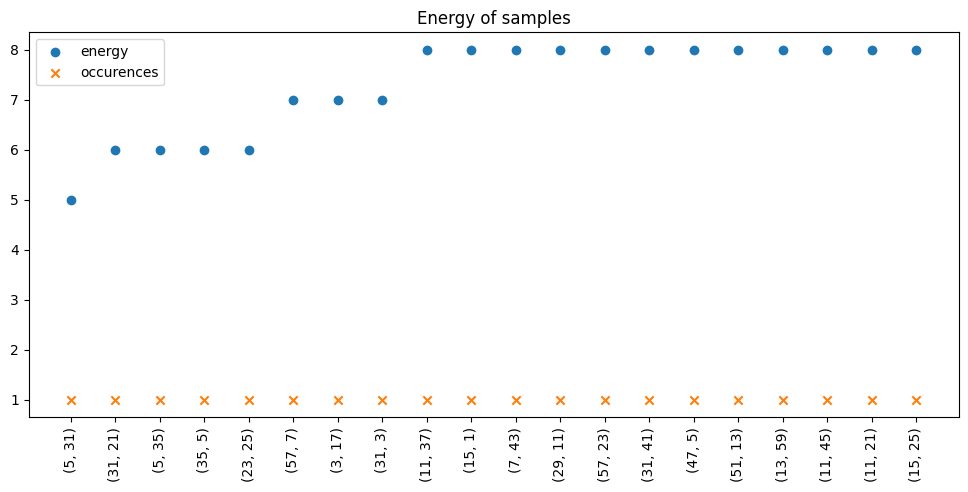

First 10 occurences: [((5, 31), [5.0, 1]), ((31, 21), [6.0, 1]), ((5, 35), [6.0, 1]), ((35, 5), [6.0, 1]), ((23, 25), [6.0, 1]), ((57, 7), [7.0, 1]), ((3, 17), [7.0, 1]), ((31, 3), [7.0, 1]), ((11, 37), [8.0, 1]), ((15, 1), [8.0, 1])]


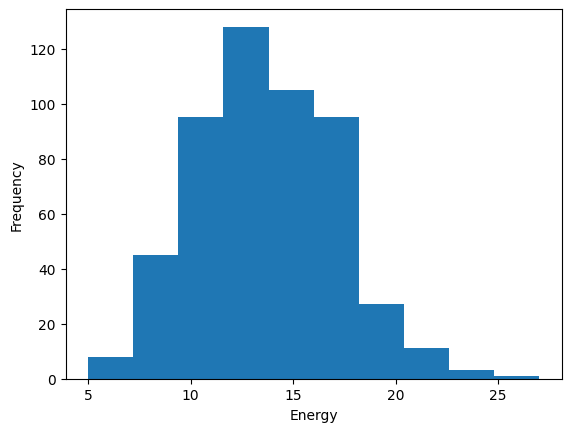

In [34]:
lc_sample_analysis(sampleset, num_bits, target_number)

In [39]:
Q, var_ind, block_LHS = QUBO_Jiang(target_number, num_bits, t_penalty_multiplier, block_size)
print_QUBO(Q, len(var_ind))

Raw columns:
col0: + 1*
col1: + 1*p1 + 1*q1
col2: + 1*p2 + 1*t1_1 + 1*q2
col3: + 1*p3 + 1*t2_1 + 1*t1_2 + 1*q3
col4: + 1*p4 + 1*t3_1 + 1*t2_2 + 1*t1_3 + 1*q4
col5: + 1*p5 + 1*t4_1 + 1*t3_2 + 1*t2_3 + 1*t1_4 + 1*q5
col6: + 1*t5_1 + 1*t4_2 + 1*t3_3 + 1*t2_4 + 1*t1_5
col7: + 1*t5_2 + 1*t4_3 + 1*t3_4 + 1*t2_5
col8: + 1*t5_3 + 1*t4_4 + 1*t3_5
col9: + 1*t5_4 + 1*t4_5
col10: + 1*t5_5
col11:

Block setup: [[1, 2, 3], [4, 5, 6], [7, 8, 9, 10, 11]]
Number of carries for each block: [3, 4, 1]

Columns with carry bits:
col0: + 1*
col1: + 1*p1 + 1*q1
col2: + 1*p2 + 1*t1_1 + 1*q2
col3: + 1*p3 + 1*t2_1 + 1*t1_2 + 1*q3
col4: + 1*p4 + 1*t3_1 + 1*t2_2 + 1*t1_3 + 1*q4 + 1*c_0_0
col5: + 1*p5 + 1*t4_1 + 1*t3_2 + 1*t2_3 + 1*t1_4 + 1*q5 + 1*c_0_1
col6: + 1*t5_1 + 1*t4_2 + 1*t3_3 + 1*t2_4 + 1*t1_5 + 1*c_0_2
col7: + 1*t5_2 + 1*t4_3 + 1*t3_4 + 1*t2_5 + 1*c_1_0
col8: + 1*t5_3 + 1*t4_4 + 1*t3_5 + 1*c_1_1
col9: + 1*t5_4 + 1*t4_5 + 1*c_1_2
col10: + 1*t5_5 + 1*c_1_3
col11:

Block equation LHS:
block0: + 1*p1 + 1*q1 

In [40]:
sampleset = embedding_sampler.sample_qubo(Q, num_reads=1000, label="Factorization", annealing_time=500, chain_strength=100)

{'p1': 1, 'p2': 1, 'p3': 1, 'p4': 0, 'p5': 0, 'q1': 1, 'q2': 1, 'q3': 0, 'q4': 1, 'q5': 0, 't1_1': 1, 't1_2': 1, 't1_3': 1, 't1_4': 1, 't1_5': 0, 't2_1': 1, 't2_2': 1, 't2_3': 0, 't2_4': 0, 't2_5': 0, 't3_1': 1, 't3_2': 1, 't3_3': 0, 't3_4': 1, 't3_5': 0, 't4_1': 0, 't4_2': 0, 't4_3': 0, 't4_4': 1, 't4_5': 0, 't5_1': 1, 't5_2': 1, 't5_3': 0, 't5_4': 0, 't5_5': 0, 'c_0_0': 0, 'c_0_1': 1, 'c_0_2': 0, 'c_1_0': 0, 'c_1_1': 1, 'c_1_2': 0, 'c_1_3': 0}
First solution: (15, 23), E = 488.0
First 10 number of occurences: [((15, 23, 488.0), 1), ((21, 31, 590.0), 1), ((13, 31, 612.0), 1), ((1, 63, 639.0), 1), ((15, 61, 651.0), 1), ((15, 47, 687.0), 1), ((15, 49, 727.0), 1), ((57, 31, 730.0), 1), ((29, 11, 739.0), 1), ((47, 33, 743.0), 1)]
first 10 t-breaks: [((15, 23, 488.0), 5), ((21, 31, 590.0), 5), ((13, 31, 612.0), 5), ((1, 63, 639.0), 6), ((15, 61, 651.0), 6), ((15, 47, 687.0), 4), ((15, 49, 727.0), 4), ((57, 31, 730.0), 6), ((29, 11, 739.0), 7), ((47, 33, 743.0), 6)]
first 10 block breaks: [

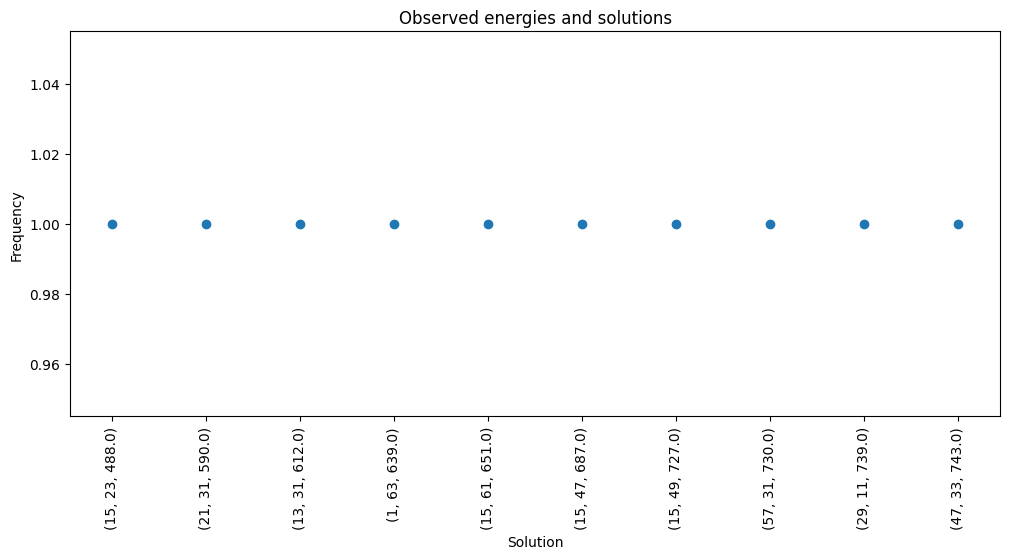

In [41]:
Jiang_sample_analysis(sampleset, var_ind, block_LHS, num_bits, target_number)

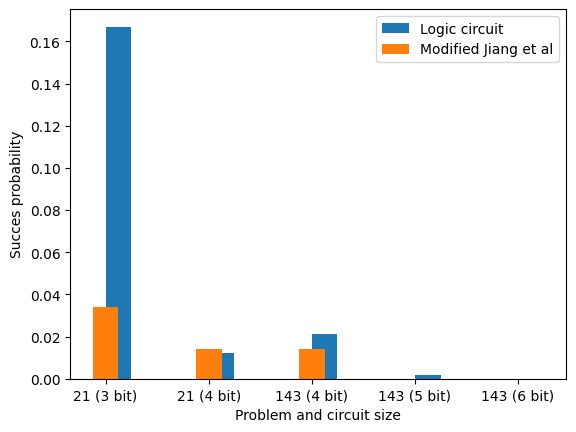

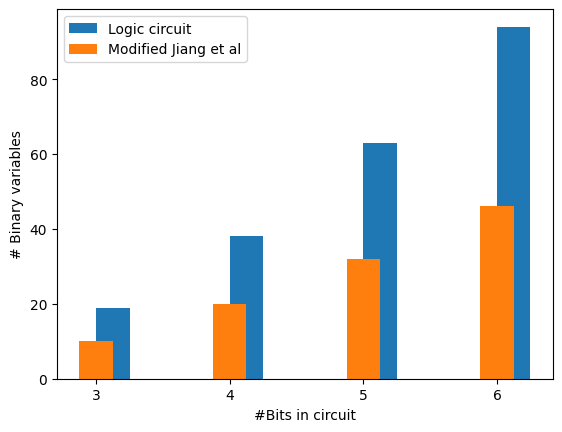

In [45]:
#Make graph of results
LC_arr = np.array([167, 12, 21, 2, 0]) / 1000
Jiang_arr = np.array([34, 14, 14, 0, 0]) / 1000
Problem_arr = ["21 (3 bit)", "21 (4 bit)", "143 (4 bit)", "143 (5 bit)", "143 (6 bit)"]

plt.figure()
plt.xlabel("Problem and circuit size")
plt.ylabel("Succes probability")
plt.bar(Problem_arr, LC_arr, label="Logic circuit", width=0.25, align='edge')
plt.bar(Problem_arr, Jiang_arr, label="Modified Jiang et al", width=0.25)
plt.legend()
plt.show()

LC_var_arr = [19, 38, 63, 94]
Jiang_var_arr = [10, 20, 32, 46]

Var_arr = ['3', '4', '5', '6']

plt.figure()
plt.xlabel("#Bits in circuit")
plt.ylabel("# Binary variables")
plt.bar(Var_arr, LC_var_arr, label="Logic circuit", width=0.25, align='edge')
plt.bar(Var_arr, Jiang_var_arr, label="Modified Jiang et al", width=0.25)
plt.legend()
plt.show()